<a href="https://colab.research.google.com/github/OlamidotunT/Big-Data-Project/blob/main/BBC_News_Article_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBC News Article Analysis

This notebook performs an analysis of the BBC News dataset, focusing on classifying articles into subcategories, extracting named entities with their job roles, and identifying mentions of events in April.

**Dataset:** The dataset used is the BBC Full Text dataset available from UCD (http://mlg.ucd.ie/datasets/bbc.html).

## Data Loading and Initial Exploration

The following cells load the data from the uploaded zip file and perform initial exploration to understand the structure and content of the dataset.

In [32]:
df_bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [31]:
import zipfile
import pandas as pd
import os

# Define paths
uploaded_zip_path = "/content/bbc-fulltext.zip"
extract_path = "/mnt/data/bbc"

# Extract uploaded ZIP file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Traverse extracted files and load into a DataFrame
data = []
bbc_text_path = os.path.join(extract_path, "bbc")
for category_folder in os.listdir(bbc_text_path):
    category_path = os.path.join(bbc_text_path, category_folder)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
                data.append({"category": category_folder, "text": text})

# Create DataFrame
df_bbc = pd.DataFrame(data)
df_bbc.head()


,category,text
0,entertainment,Wal-Mart is sued over rude lyrics\n\nThe paren...
1,entertainment,Grammys honour soul star Charles\n\nThe memory...
2,entertainment,Black Sabbath top rock album poll\n\nBlack Sab...
3,entertainment,Abba reunite for musical premiere\n\nThe origi...
4,entertainment,"Beatles suits sell for $110,000\n\nFour suits ..."


In [33]:
df_bbc.describe()

,category,text
count,2225,2225
unique,5,2127
top,sport,US duo in first spam conviction\n\nA brother a...
freq,511,2


In [34]:
print(df_bbc["category"].unique())


['entertainment' 'politics' 'business' 'sport' 'tech']


In [35]:
print(df_bbc["category"].value_counts())


category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


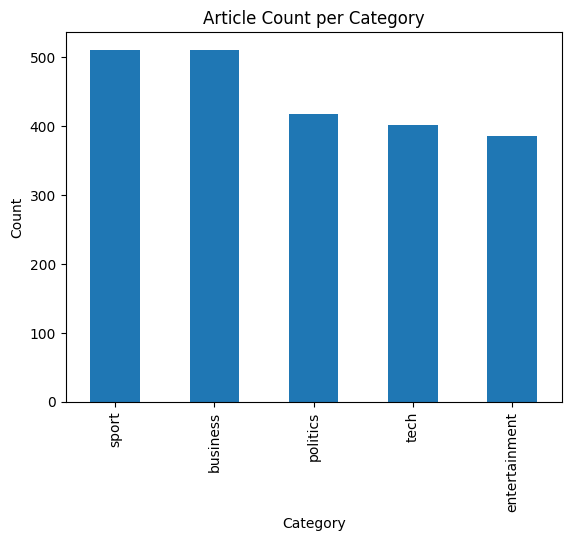

In [36]:
import matplotlib.pyplot as plt

df_bbc["category"].value_counts().plot(kind="bar", title="Article Count per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


In [37]:
for cat in df_bbc["category"].unique():
    sample = df_bbc[df_bbc["category"] == cat].iloc[0]
    print(f"\n🗂️ Category: {cat}\n📝 Text:\n{sample['text'][:500]}...\n{'-'*80}")



🗂️ Category: entertainment
📝 Text:
Wal-Mart is sued over rude lyrics

The parents of a 13-year-old girl are suing US supermarket giant Wal-Mart over a CD by rock group Evanescence that contains swear words.

The lawsuit, filed in Washington County, alleges Wal-Mart deceived customers by not putting warning labels on the cover. Trevin Skeens alleges Wal-Mart knew of the offending word because it had censored it on its music sales website. Wal-Mart said it was investigating the claims but had no plans to pull the CD. Wal-Mart has a...
--------------------------------------------------------------------------------

🗂️ Category: politics
📝 Text:
MP's shock at long lost daughter

Labour MP Stephen Pound has told of his shock and his joy on learning he fathered a daughter when he was "out of control" during the "wild" 1960s.

Lucy, 36, tracked down Mr Pound after her birth mother told her he was known as "Precious" at school. Despite being told he was a "nutter who died at sea" she found a

In [38]:
from collections import Counter

def get_top_words(texts, n=10):
    words = " ".join(texts).lower().split()
    return Counter(words).most_common(n)

for cat in df_bbc["category"].unique():
    texts = df_bbc[df_bbc["category"] == cat]["text"]
    print(f"\n📊 Top words in {cat}: {get_top_words(texts)}")



📊 Top words in entertainment: [('the', 8157), ('and', 3000), ('of', 2963), ('to', 2875), ('in', 2769), ('a', 2700), ('for', 1527), ('on', 1157), ('was', 1133), ('is', 1064)]

📊 Top words in politics: [('the', 11952), ('to', 5965), ('of', 4454), ('and', 3916), ('a', 3840), ('in', 3311), ('he', 2148), ('for', 1884), ('on', 1811), ('is', 1808)]

📊 Top words in business: [('the', 10606), ('to', 5059), ('of', 4371), ('in', 4288), ('a', 3394), ('and', 3186), ('is', 1599), ('for', 1595), ('that', 1553), ('on', 1348)]

📊 Top words in sport: [('the', 9450), ('to', 4673), ('a', 3836), ('and', 3626), ('in', 3589), ('of', 2793), ('for', 1723), ('he', 1520), ('is', 1470), ('on', 1460)]

📊 Top words in tech: [('the', 11515), ('to', 6296), ('of', 5338), ('and', 4679), ('a', 4314), ('in', 3401), ('that', 2530), ('is', 2512), ('for', 2069), ('it', 1838)]


## Subcategory Classification

This section implements a rule-based approach to classify articles into more specific subcategories within the main categories (Business, Entertainment, Sport, Politics, Tech) based on keyword matching.

In [39]:
def subcat_business(text):
    text = text.lower()
    if any(w in text for w in ['stock', 'market', 'share', 'index']):
        return 'stock market'
    if any(w in text for w in ['merger', 'acquisition', 'takeover', 'buyout']):
        return 'mergers and acquisitions'
    if any(w in text for w in ['company', 'corporate', 'firm', 'business']):
        return 'company news'
    return 'other business'


In [40]:
def subcat_entertainment(text):
    text = text.lower()
    if any(w in text for w in ['cinema', 'movie', 'film', 'hollywood', 'oscar']):
        return 'cinema'
    if any(w in text for w in ['theatre', 'play', 'drama', 'broadway']):
        return 'theatre'
    if any(w in text for w in ['music', 'concert', 'album', 'band', 'song', 'singer']):
        return 'music'
    if any(w in text for w in ['book', 'literature', 'novel', 'author', 'writing']):
        return 'literature'
    if any(w in text for w in ['celebrity', 'personality', 'star', 'actor', 'actress']):
        return 'personality'
    return 'other entertainment'


In [41]:
def subcat_sport(text):
    text = text.lower()
    if any(w in text for w in ['cricket', 'test match', 'one day', 'odi', 'batsman']):
        return 'cricket'
    if any(w in text for w in ['football', 'soccer', 'fifa', 'goal', 'premier league']):
        return 'football'
    if any(w in text for w in ['olympics', 'olympic', 'athletics', 'swimming', 'gymnastics']):
        return 'olympics'
    if any(w in text for w in ['tennis', 'wimbledon', 'grand slam']):
        return 'tennis'
    return 'other sport'


In [42]:
def subcat_politics(text):
    text = text.lower()
    if any(w in text for w in ['election', 'vote', 'campaign', 'party']):
        return 'elections'
    if any(w in text for w in ['policy', 'government', 'law', 'bill']):
        return 'policy'
    if any(w in text for w in ['diplomacy', 'foreign', 'international', 'treaty']):
        return 'foreign affairs'
    return 'other politics'


In [43]:
def subcat_tech(text):
    text = text.lower()
    if any(w in text for w in ['software', 'app', 'application', 'programming']):
        return 'software'
    if any(w in text for w in ['hardware', 'chip', 'processor', 'device']):
        return 'hardware'
    if any(w in text for w in ['internet', 'web', 'online', 'cloud']):
        return 'internet'
    if any(w in text for w in ['ai', 'artificial intelligence', 'machine learning']):
        return 'AI/ML'
    return 'other tech'


In [44]:
def classify_subcategory(row):
    cat = row['category']
    text = row['text']

    if cat == 'business':
        return subcat_business(text)
    elif cat == 'entertainment':
        return subcat_entertainment(text)
    elif cat == 'sport':
        return subcat_sport(text)
    elif cat == 'politics':
        return subcat_politics(text)
    elif cat == 'tech':
        return subcat_tech(text)
    else:
        return 'unknown'

df_bbc['subcategory'] = df_bbc.apply(classify_subcategory, axis=1)


In [45]:
print(df_bbc.groupby(['category', 'subcategory']).size())


category       subcategory             
business       company news                103
               mergers and acquisitions      7
               other business               56
               stock market                344
entertainment  cinema                      211
               literature                   14
               music                        75
               other entertainment           9
               personality                   8
               theatre                      69
politics       elections                   297
               foreign affairs               7
               other politics               13
               policy                      100
sport          cricket                      27
               football                    165
               olympics                     75
               other sport                 175
               tennis                       69
tech           AI/ML                        27
               hardw

## Named Entity Recognition and Job Extraction

Using the spaCy library, this section identifies named entities (specifically persons) within the articles and attempts to determine their job roles based on surrounding keywords.

In [46]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [47]:
subcategory_keywords = {
    'business': {
        'stock market': ['stock market', 'shares', 'stocks', 'shares plunge', 'stock exchange'],
        'company news': ['company', 'firm', 'corporate', 'business group', 'company news'],
        'mergers and acquisitions': ['merger', 'acquisition', 'takeover', 'buyout'],
        'other business': []
    },
    'entertainment': {
        'cinema': ['film', 'movie', 'cinema', 'director', 'actor', 'actress'],
        'theatre': ['theatre', 'play', 'drama', 'stage'],
        'music': ['music', 'album', 'band', 'singer', 'concert'],
        'literature': ['book', 'author', 'literature', 'novel', 'writer'],
        'personality': ['celebrity', 'star', 'personality'],
        'other entertainment': []
    },
    'politics': {
        'elections': ['election', 'vote', 'poll', 'candidate'],
        'foreign affairs': ['foreign', 'diplomatic', 'international', 'embassy'],
        'policy': ['policy', 'government plan', 'law', 'bill'],
        'other politics': []
    },
    'sport': {
        'football': ['football', 'soccer', 'premier league', 'goal'],
        'cricket': ['cricket', 'test match', 'odi', 'batsman'],
        'olympics': ['olympic', 'paralympic', 'games', 'medal'],
        'tennis': ['tennis', 'grand slam', 'atp', 'wimbledon'],
        'other sport': []
    },
    'tech': {
        'AI/ML': ['ai', 'machine learning', 'artificial intelligence', 'deep learning'],
        'hardware': ['hardware', 'processor', 'chip', 'gpu'],
        'software': ['software', 'application', 'app', 'programming', 'platform'],
        'internet': ['internet', 'web', 'online', 'browser'],
    }
}

def assign_subcategory(row):
    category = row['category']
    text = row['text'].lower()
    subcats = subcategory_keywords.get(category, {})
    for subcat, keywords in subcats.items():
        if any(kw in text for kw in keywords):
            return subcat
    # fallback to 'other' subcategory if no keyword matched
    return f"other {category}"

df_bbc['subcategory'] = df_bbc.apply(assign_subcategory, axis=1)


In [48]:
import spacy

nlp = spacy.load('en_core_web_sm')

job_keywords = {
    'politician': ['mp', 'politician', 'minister', 'president', 'senator', 'government'],
    'tv/film personality': ['actor', 'actress', 'director', 'film', 'tv', 'show', 'celebrity', 'star'],
    'musician': ['singer', 'band', 'musician', 'album', 'concert', 'music'],
}

def extract_person_jobs(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            # Look at context +/- 10 tokens around person
            start = max(ent.start - 10, 0)
            end = min(ent.end + 10, len(doc))
            context = doc[start:end].text.lower()
            job = 'unknown'
            for job_title, keywords in job_keywords.items():
                if any(k in context for k in keywords):
                    job = job_title
                    break
            entities.append({'person': ent.text, 'job': job})
    return entities

df_bbc['named_entities'] = df_bbc['text'].apply(extract_person_jobs)


## April Event Extraction

This section extracts sentences from the articles that mention the month of April and include keywords related to events or scheduling.

In [49]:
import re

def extract_april_events(text):
    doc = nlp(text)
    april_sents = []
    for sent in doc.sents:
        if re.search(r'\bApril\b', sent.text, re.I) and re.search(r'\b(schedule|scheduled|took place|event|date|occurred|held|will be|is on|takes place)\b', sent.text, re.I):
            april_sents.append(sent.text.strip())
    return ' '.join(april_sents)

df_bbc['april_events'] = df_bbc['text'].apply(extract_april_events)


In [50]:
print(df_bbc[['category', 'subcategory', 'named_entities', 'april_events']].head(10))


        category subcategory  \
0  entertainment     theatre   
1  entertainment      cinema   
2  entertainment     theatre   
3  entertainment     theatre   
4  entertainment       music   
5  entertainment     theatre   
6  entertainment      cinema   
7  entertainment      cinema   
8  entertainment       music   
9  entertainment     theatre   

                                      named_entities april_events  
0  [{'person': 'Evanescence', 'job': 'unknown'}, ...               
1  [{'person': 'Charles

', 'job': 'tv/film perso...               
2  [{'person': 'Black Sabbath', 'job': 'musician'...               
3  [{'person': 'Abba', 'job': 'tv/film personalit...               
4  [{'person': 'Beatles', 'job': 'musician'}, {'p...               
5  [{'person': 'Scissor Sisters', 'job': 'politic...               
6  [{'person': 'Gail Berman', 'job': 'unknown'}, ...               
7  [{'person': 'Leonardo DiCaprio', 'job': 'tv/fi...               
8  [{'person': 'McFadden', 'job': '

In [51]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_person_jobs(text):
    doc = nlp(text)
    results = []
    job_keywords = {
        'politician': ['mp', 'politician', 'minister', 'president', 'senator', 'government'],
        'tv/film personality': ['actor', 'actress', 'director', 'film', 'tv', 'show', 'celebrity', 'star'],
        'musician': ['singer', 'band', 'musician', 'album', 'concert', 'song', 'music'],
    }
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            # Search for job keywords in a small window of tokens around the entity
            ent_start = ent.start
            ent_end = ent.end
            window_start = max(ent_start - 10, 0)
            window_end = min(ent_end + 10, len(doc))
            context_tokens = doc[window_start:window_end].text.lower()
            # Find matching job type
            job_found = None
            for job, keywords in job_keywords.items():
                if any(k in context_tokens for k in keywords):
                    job_found = job
                    break
            results.append({'person': ent.text, 'job': job_found if job_found else 'unknown'})
    return results

# Example: Extract for first few texts in dataframe
for i, row in df_bbc.head(5).iterrows():
    print(f"--- Article {i} ---")
    entities = extract_person_jobs(row['text'])
    for e in entities:
        print(f"Person: {e['person']} - Job: {e['job']}")


--- Article 0 ---
Person: Evanescence - Job: unknown
Person: Trevin Skeens - Job: unknown
Person: Skeens - Job: unknown
Person: Anywhere - Job: unknown
Person: Skeens - Job: unknown
Person: Guy Whitcomb - Job: unknown
--- Article 1 ---
Person: Charles

 - Job: tv/film personality
Person: Ray Charles - Job: tv/film personality
Person: Grammy Awards - Job: musician
Person: Charles - Job: unknown
Person: Alicia Keys - Job: tv/film personality
Person: Jamie Foxx - Job: tv/film personality
Person: Keys - Job: tv/film personality
Person: Grammy - Job: tv/film personality
Person: Norah Jones - Job: unknown
Person: Kanye West - Job: unknown
Person: Charles - Job: politician
Person: Norah Jones - Job: musician
Person: Gladys Knight - Job: unknown
Person: Jones - Job: unknown
Person: Jamie Foxx - Job: tv/film personality
Person: Oscar - Job: tv/film personality
Person: Charles - Job: unknown
Person: Ray - Job: unknown
Person: Keys - Job: unknown
Person: Lil Jon and - Job: unknown
Person: Ludacri

In [52]:
df_bbc['named_entities'] = df_bbc['text'].apply(extract_person_jobs)
df_bbc['april_events'] = df_bbc['text'].apply(extract_april_events)

# Save or review the dataframe
df_bbc[['category', 'subcategory', 'named_entities', 'april_events']].head(10)


,category,subcategory,named_entities,april_events
0,entertainment,theatre,"[{'person': 'Evanescence', 'job': 'unknown'}, ...",
1,entertainment,cinema,"[{'person': 'Charles ', 'job': 'tv/film perso...",
2,entertainment,theatre,"[{'person': 'Black Sabbath', 'job': 'musician'...",
3,entertainment,theatre,"[{'person': 'Abba', 'job': 'tv/film personalit...",
4,entertainment,music,"[{'person': 'Beatles', 'job': 'musician'}, {'p...",
5,entertainment,theatre,"[{'person': 'Scissor Sisters', 'job': 'politic...",
6,entertainment,cinema,"[{'person': 'Gail Berman', 'job': 'unknown'}, ...",
7,entertainment,cinema,"[{'person': 'Leonardo DiCaprio', 'job': 'tv/fi...",
8,entertainment,music,"[{'person': 'McFadden', 'job': 'musician'}, {'...",
9,entertainment,theatre,"[{'person': 'Charlie Simpson', 'job': 'politic...",


## Data Visualization

The following cell visualize the distributions of categories, subcategories, named entity job roles, and April events to provide a better understanding of the data.

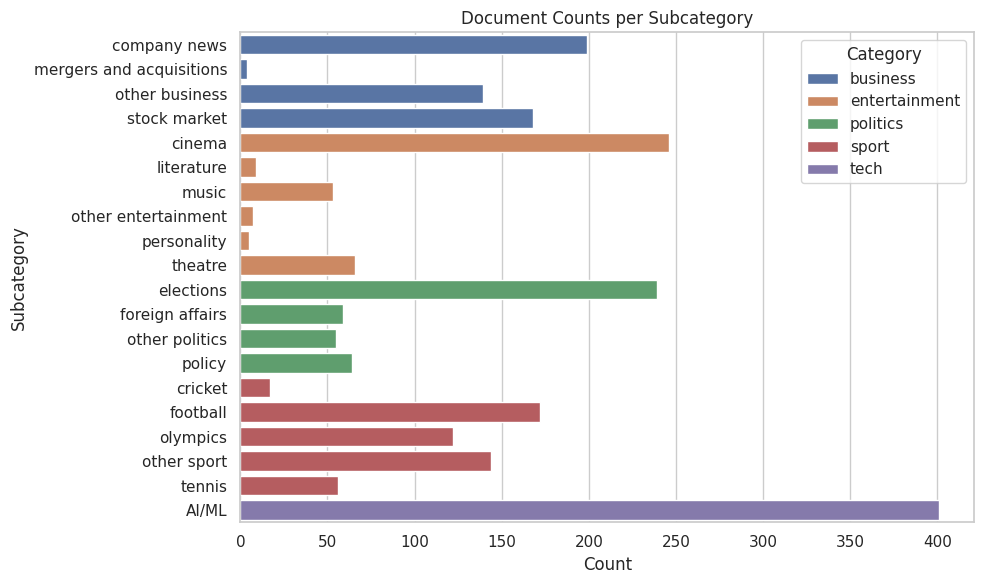

/tmp/ipython-input-58-1458729590.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=job_df, x='count', y='job', palette='Set2')


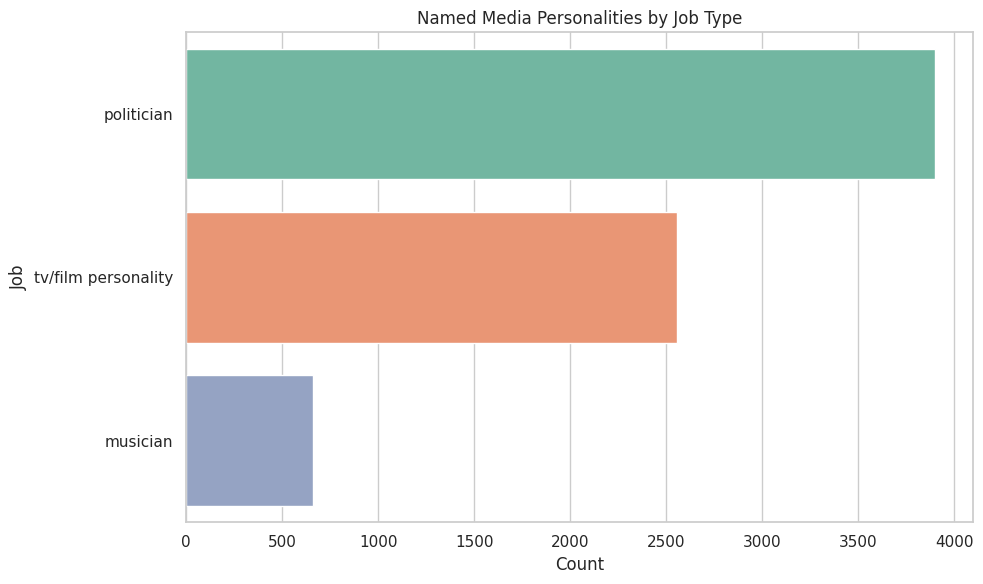

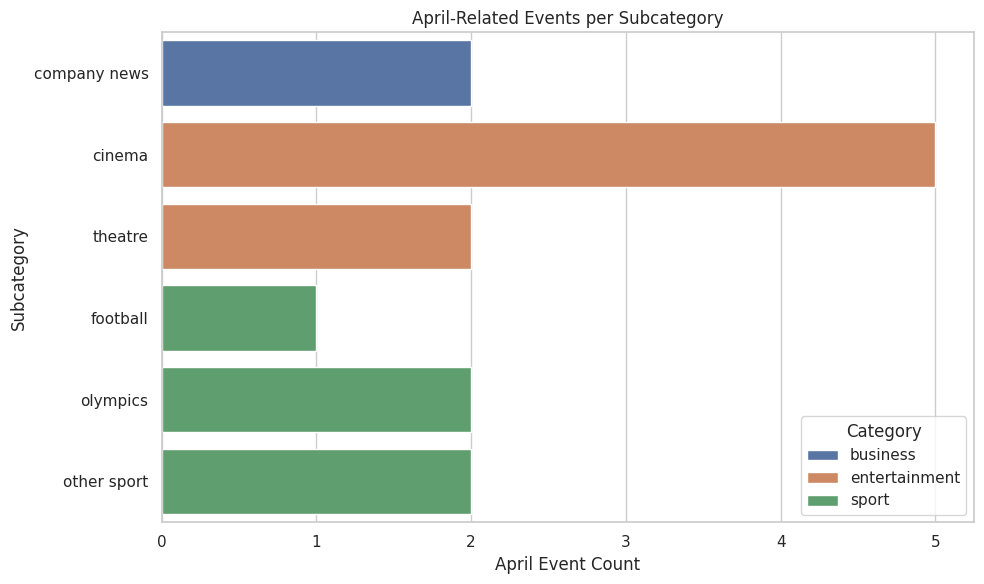

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load your final dataframe
# df should have: category, subcategory, named_entities, april_events
# If named_entities are stored as strings (JSON-like), convert to list
df_bbc['named_entities'] = df_bbc['named_entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Set plot style
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (10, 6)})

# --- 1. Subcategory Distribution per Category ---
plt.figure()
subcat_counts = df_bbc.groupby(['category', 'subcategory']).size().reset_index(name='count')
sns.barplot(data=subcat_counts, x='count', y='subcategory', hue='category')
plt.title("Document Counts per Subcategory")
plt.xlabel("Count")
plt.ylabel("Subcategory")
plt.legend(title='Category')
plt.tight_layout()
plt.show()

# --- 2. Named Entity Job Distribution ---
from collections import Counter

# Flatten all job roles
jobs = [entity['job'].lower() for entities in df_bbc['named_entities'] for entity in entities if entity['job'] != 'unknown']
job_counts = Counter(jobs)
job_df = pd.DataFrame(job_counts.items(), columns=['job', 'count']).sort_values(by='count', ascending=False)

plt.figure()
sns.barplot(data=job_df, x='count', y='job', palette='Set2')
plt.title("Named Media Personalities by Job Type")
plt.xlabel("Count")
plt.ylabel("Job")
plt.tight_layout()
plt.show()

# --- 3. April Events Count by Subcategory ---
april_df = df_bbc[df_bbc['april_events'].notnull() & df_bbc['april_events'].astype(str).str.strip().ne('')]
april_counts = april_df.groupby(['category', 'subcategory']).size().reset_index(name='april_event_count')

plt.figure()
sns.barplot(data=april_counts, x='april_event_count', y='subcategory', hue='category')
plt.title("April-Related Events per Subcategory")
plt.xlabel("April Event Count")
plt.ylabel("Subcategory")
plt.legend(title='Category')
plt.tight_layout()
plt.show()


In [3]:
# Replace "Your Name or Email Address" with your actual name or email
identification = "olutayooladotun@gmail.com"

# Define the file name
file_name = "Timothy_Egbejinmi.txt"

# Write the information to the file
with open(file_name, "w") as f:
    f.write(identification)

print(f"File '{file_name}' created successfully with your identification.")

File 'Timothy_Egbejinmi.txt' created successfully with your identification.
